# Graph Neural Network를 사용한 Semi-supervised Community Detection

거의 모든 컴퓨터 개론 강의는 "Hello World" 예제로 시작합니다. 딥러닝의 MNIST처럼, 그래프 도메인에서는 'Zachary의 카라테 클럽' 예제가 있습니다.  
'카라테 클럽'은 소셜 네트워크로, 34명의 멤버와 클럽 외부에서 교류하는 멤버들 사이의 쌍별 관계를 담은 문서를 포함하고 있습니다.  
이 클럽은 2개의 커뮤니티로 나뉘어, 지도자 (노드 0번)와 클럽 회장(노드 33번)가 각각 커뮤니티를 이끌게 됩니다.  
네트워크는 아래처럼 시각화되며, 색상은 커뮤니티를 나타냅니다.


<img src='../asset/karat_club.png' align='center' width="400px" height="300px" />

In this tutorial, you will learn:
이 튜토리얼에서 배울 수 있는 것:


* 커뮤니티 감지 문제를 semi-supervised 노드 분류 태스크로 다룹니다.

* GraphSAGE 모델을 구축합니다. GraphSAGE는 유명한 GNN 아키텍처로, Hamilton et al.의 [이 논문](https://arxiv.org/abs/1706.02216)에서 제안되었습니다.

* 모델을 학습하고 결과를 이해합니다.


In [2]:
import dgl
import torch
import torch.nn as nn
import torch.nn.functional as F
import itertools

Using backend: pytorch


## 노드 분류로써의 커뮤니티 감지

그래프 내의 커뮤니티 구조(structure)에 대한 연구는 긴 역사를 가지고 있습니다.   
제안된 방법 중 다수는 *비지도적인* 방법론인데(혹은 최근 정의로는 *self-supervised*), 이는 모델이 커뮤니티의 라벨을 오직 연결 관계에 근거하여 예측하는 방법을 말합니다.  

최근, [Kipf et al.,](https://arxiv.org/abs/1609.02907)은 커뮤니티 감지 문제를 semi-supervised 노드 분류 문제로 다루는 방법을 제안했습니다.   
단지 일부분의 라벨이 붙은 노드만으로도, GNN은 다른 노드들의 커뮤니티 라벨을 정확하게 예측할 수 있습니다.  

이 튜토리얼에서, Kipf의 설정을 Zachery의 카라테 클럽 네트워크에 적용하여 커뮤니티의 멤버 구성을 예측해 보겠습니다. 몇개 노드의 라벨만 알려진 상태에서 말이지요.


먼저 그래프와 노드 라벨을 [첫번째 튜토리얼](./1_load_data.ipynb)에서 다뤘던 것처럼 로드해 봅시다.  
여기서는, 데이터를 적재하는 함수를 제공합니다.

In [4]:
from tutorial_utils import load_zachery

# ----------- 0. load graph -------------- #
g = load_zachery()
print(g)

Graph(num_nodes=34, num_edges=156,
      ndata_schemes={'club': Scheme(shape=(), dtype=torch.int64), 'club_onehot': Scheme(shape=(2,), dtype=torch.int64)}
      edata_schemes={})


원래의 Zachery 카라테 클럽 그래프에서는, 노드에 피처가 없습니다 (`'Age'` 특성은 튜토리얼을 위해 인공적으로 만든 피처입니다).  
피처가 없는 그래프에서는, 일반적인 관행은 각 노드에 대해 학습 도중에 업데이트되는 임베딩 가중치를 사용하는 것입니다.

여기서는 파이토치의 `Embedding` 모듈을 이용해 보겠습니다.

In [5]:
# ----------- 1. node features -------------- #
node_embed = nn.Embedding(g.number_of_nodes(), 5)  # 각 노드는 5차원의 임베딩을 가지고 있습니다.
inputs = node_embed.weight                         # 노드 피처로써 이 임베딩 가중치를 사용합니다.

In [6]:
nn.init.xavier_uniform_(inputs)
print(inputs)

Parameter containing:
tensor([[ 0.1540, -0.2952,  0.0624,  0.3412, -0.1033],
        [-0.2919,  0.2127,  0.1182,  0.3554, -0.0934],
        [-0.3652,  0.3878,  0.1286,  0.2028,  0.2655],
        [ 0.1315, -0.1676,  0.0308, -0.1929,  0.3055],
        [-0.1061, -0.3236,  0.1865, -0.3340, -0.3600],
        [-0.3554, -0.3214, -0.0008, -0.0017,  0.2396],
        [-0.1150, -0.3310,  0.2526, -0.3571,  0.1516],
        [ 0.2880,  0.3198,  0.3236,  0.1512,  0.0440],
        [ 0.1427, -0.3203,  0.1103, -0.3800, -0.3186],
        [ 0.1434, -0.1268, -0.0996,  0.0643, -0.2870],
        [-0.0182,  0.1564, -0.3637,  0.2550,  0.0406],
        [-0.1376, -0.2601, -0.2874, -0.0472, -0.3122],
        [ 0.3788, -0.2387,  0.2840, -0.2374,  0.1948],
        [ 0.1656, -0.2318,  0.1911,  0.3527,  0.2320],
        [-0.1292,  0.3377,  0.1848, -0.3116,  0.0489],
        [ 0.2463,  0.0368,  0.1417, -0.2213, -0.0431],
        [ 0.2400,  0.2034, -0.1923, -0.1086, -0.3901],
        [ 0.0598, -0.2281,  0.2019, -0.1112


커뮤니티의 라벨은 `'club'`이라는 노드 피처에 저장되어 있습니다. (0은 instructor의 커뮤니티, 1은 club president의 커뮤니티).  
오로지 0과 33번 노드에만 라벨링 되어 있습니다.

In [7]:
labels = g.ndata['club']
labeled_nodes = [0, 33]
print('Labels', labels[labeled_nodes])

Labels tensor([0, 1])


## GraphSAGE 모델 정의하기

우리의 모델은 2개 레이어로 구성되어 있는데, 각각 새로운 노드 표현(representation)을 이웃의 정보를 통합함으로써 계산합니다.  
수식은 다음과 같습니다.  


$$
h_{\mathcal{N}(v)}^k\leftarrow \text{AGGREGATE}_k\{h_u^{k-1},\forall u\in\mathcal{N}(v)\}
$$

$$
h_v^k\leftarrow \sigma\left(W^k\cdot \text{CONCAT}(h_v^{k-1}, h_{\mathcal{N}(v)}^k) \right)
$$

DGL은 많은 유명한 이웃 통합(neighbor aggregation) 모듈의 구현체를 제공합니다. 모두 쉽게 한 줄의 코드로 호출하여 사용할 수 있습니다.  
지원되는 모델의 전체 리스트는 [graph convolution modules](https://docs.dgl.ai/api/python/nn.pytorch.html#module-dgl.nn.pytorch.conv)에서 보실 수 있습니다.

In [8]:
from dgl.nn import SAGEConv

# ----------- 2. create model -------------- #
# 2개의 레이어를 가진 GraphSAGE 모델 구축

class GraphSAGE(nn.Module):
    def __init__(self, in_feats, h_feats, num_classes):
        super(GraphSAGE, self).__init__()
        self.conv1 = SAGEConv(in_feats, h_feats, 'mean')
        self.conv2 = SAGEConv(h_feats, num_classes, 'mean')
    
    def forward(self, g, in_feat):
        h = self.conv1(g, in_feat)
        h = F.relu(h)
        h = self.conv2(g, h)
        return h
    
    
# 주어진 차원의 모델 생성
# 인풋 레이어 차원: 5, 노드 임베딩
# 히든 레이어 차원: 16
# 아웃풋 레이어 차원: 2, 클래스가 2개 있기 때문, 0과 1

net = GraphSAGE(5, 16, 2)

In [9]:
# ----------- 3. set up loss and optimizer -------------- #
# 이 경우, 학습 루프의 손실
optimizer = torch.optim.Adam(itertools.chain(net.parameters(), node_embed.parameters()), lr=0.01)

# ----------- 4. training -------------------------------- #
all_logits = []
for e in range(100):
    # forward
    logits = net(g, inputs)
    
    # 손실 계산
    logp = F.log_softmax(logits, 1)
    loss = F.nll_loss(logp[labeled_nodes], labels[labeled_nodes])
    
    # backward
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    all_logits.append(logits.detach())
    
    if e % 5 == 0:
        print('In epoch {}, loss: {}'.format(e, loss))

In epoch 0, loss: 0.7599985003471375
In epoch 5, loss: 0.5178183913230896
In epoch 10, loss: 0.33661043643951416
In epoch 15, loss: 0.1764797568321228
In epoch 20, loss: 0.07109666615724564
In epoch 25, loss: 0.025459131225943565
In epoch 30, loss: 0.009772809222340584
In epoch 35, loss: 0.004418826662003994
In epoch 40, loss: 0.0023929956369102
In epoch 45, loss: 0.0015151326078921556
In epoch 50, loss: 0.0010831437539309263
In epoch 55, loss: 0.0008459077216684818
In epoch 60, loss: 0.0007021332858130336
In epoch 65, loss: 0.0006078407168388367
In epoch 70, loss: 0.0005415981286205351
In epoch 75, loss: 0.0004920920473523438
In epoch 80, loss: 0.0004529501311480999
In epoch 85, loss: 0.0004203604767099023
In epoch 90, loss: 0.00039223843486979604
In epoch 95, loss: 0.00036733312299475074


In [10]:
# ----------- 5. check results ------------------------ #
pred = torch.argmax(logits, axis=1)
print('Accuracy', (pred == labels).sum().item() / len(pred))

Accuracy 0.3235294117647059


## 결과 시각화하기

GNN이 사이즈 각 배열별로 2의 로짓 벡터를 만들기 때문에, 2차원 평면에 그림을 그릴 수 있습니다.

<img src='./asset/gnn_ep0.png' align='center' width="400px" height="300px"/>
<img src='./asset/gnn_ep_anime.gif' align='center' width="400px" height="300px"/>

아래의 코드를 실행해 결과를 시각화해보세요. ffmpeg가 필요합니다.

In [11]:
# 약간의 셋팅을 합니다. 이 셀은 무시하셔도 됩니다.
import matplotlib.pyplot as plt

# 외부 모듈의 자동 reloading
%load_ext autoreload
%autoreload 2

%matplotlib inline
plt.rcParams['figure.figsize'] = (4.0, 3.0) # 플롯의 기본 사이즈 설정
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'
plt.rcParams['animation.html'] = 'html5'

In [12]:
len(all_logits)

100

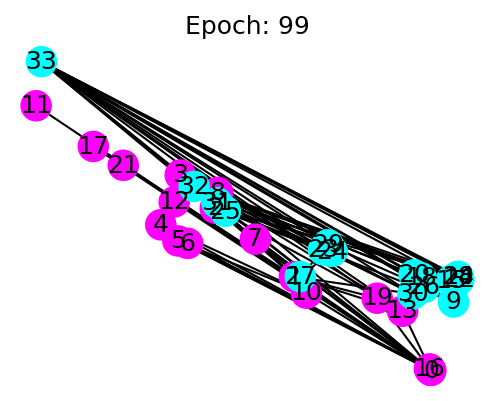

In [13]:
# 노드 분류를 로짓 출력을 사용해 시각화합니다. ffmpeg가 필요합니다.
import networkx as nx
import numpy as np
import matplotlib.animation as animation
from IPython.display import HTML

fig = plt.figure(dpi=150)
fig.clf()
ax = fig.subplots()
nx_G = g.to_networkx()
def draw(i):
    cls1color = '#00FFFF'
    cls2color = '#FF00FF'
    pos = {}
    colors = []
    for v in range(34):
        pred = all_logits[i].numpy()
        pos[v] = pred[v]
        cls = labels[v]
        colors.append(cls1color if cls else cls2color)
    ax.cla()
    ax.axis('off')
    ax.set_title('Epoch: %d' % i)
    nx.draw(nx_G.to_undirected(), pos, node_color=colors, with_labels=True, node_size=200)

ani = animation.FuncAnimation(fig, draw, frames=len(all_logits), interval=200)
HTML(ani.to_html5_video())

## Exercise

Play with the GNN models by using other [graph convolution modules](https://docs.dgl.ai/api/python/nn.pytorch.html#module-dgl.nn.pytorch.conv).